In [1]:
# Import dependencies
import pandas as pd
import datetime
import time
#from sqlalchemy import create_engine
#from config import db_password

# Read in files
df = pd.read_csv('/content/btc_data.csv')

# Display initial data
df.head(10)

# keep timestamp, high, low, weighted_price
df = df[['Timestamp', 'High', 'Low', 'Volume_(BTC)', 'Weighted_Price']].reset_index(drop=True)

# preprocessing notes-- consider omitting data prior to Jan 1st, 2012 due to higher volatility 
# earlier in bitcoin's lifecycle

# converting Timestamp column to str datatype
df['str_timestamp'] = [str(timestamp) for timestamp in df['Timestamp']]
df['int_timestamp'] = df['str_timestamp'].astype('int32', copy=True)

# filtering df to only include rows after 01/01/2012
df_cleaned_filtered = df.loc[df['int_timestamp'] >= 1325391360]
df_cleaned_filtered.head(2)

# context manager to suppress 1 time SettingWithCopyWarning; alternatively call .loc after timestamp conversion to avoid error
pd.reset_option('mode.chained_assignment')
with pd.option_context('mode.chained_assignment', None):
    df_cleaned_filtered['UTC_time'] = df_cleaned_filtered['int_timestamp'].apply(lambda x: datetime.datetime.utcfromtimestamp(x))

# dropping all null values, followed by evaluation of which time periods had the greatest data loss
final_df = df_cleaned_filtered.dropna().reset_index(drop=True)

# finding percentage of data loss (null values)
btotalLength = (len(df_cleaned_filtered))
bpartialLength = (len(final_df))
bValuesDropped = btotalLength - bpartialLength
bitstampDiff = (btotalLength - bpartialLength) / btotalLength * 100 
totalDays = round(btotalLength/1440,2)
daysDropped = round(bValuesDropped/1440,2)

print(f"Percentage of total Bitstamp data lost due to dropping rows with NaN values: {bitstampDiff:.2f}%")
print(f"Ratio of Bitstamp rows dropped: {bValuesDropped:,}/{btotalLength:,}")
print(f"Total dataset contains {totalDays} days worth of data. Due to data loss, we had to drop {daysDropped} days worth of data")

# Machine learning section
# possible implementation ideas:
# 1. time series forecasting bitcoin price with ARIMA(Auto Regressive Integrated Moving Average)
# Rational for using time series: the 4 components of time series are trends, seasonality (consistent trends that span 1 calender year), noise/irregularity, and cyclicity(trends that can be observed in <1 or >1 year); this is perfect for tradeable assets 
# Qualifying criteria: the dataset must be stationary in order to more accurately fit a time series model. Stationary means that there should be a constant mean with constant std deviation or variance
# We can test if a time series is stationary by plotting the moving avg and/or movning std dev. to see if it changes over time. These results can be supported with an ADCF test
# if testing reveals our time series is NOT stationary, we can perform a variety of transformations to change it (log transform, sq rt, exponential decay etc..)
# SARIMA is ARIMA with a seasonality component. 


# ### PGAdmin SQL Schema
# db schema thoughts: can create multiple tables for each currency (1 for btc, 1 ethereum, 1 xrp)
# can also add in additional tables down the line to support our analysis (table with google analytics, table with twitter search results for sentiment analysis)

final_df.head(5)

# Rename columns to be sql friendly
final_df.rename({'Timestamp':'timestamp',
                  'High':'high',
                  'Low':'low',
                  'Volume_(BTC)':'volume',
                  'Weighted_Price':'weightedPrice',
                  'str_timestamp':'timestampSTR',
                  'int_timestamp':'timestampINT',
                  'UTC_time':'timeUTC',
                  'time_delta':'timeDelta'
                 }, axis='columns', inplace=True)


# Checking datatypes
print(final_df.dtypes)
final_df

Percentage of total Bitstamp data lost due to dropping rows with NaN values: 27.14%
Ratio of Bitstamp rows dropped: 1,240,496/4,571,033
Total dataset contains 3174.33 days worth of data. Due to data loss, we had to drop 861.46 days worth of data
timestamp                 int64
high                    float64
low                     float64
volume                  float64
weightedPrice           float64
timestampSTR             object
timestampINT              int32
timeUTC          datetime64[ns]
dtype: object


,timestamp,high,low,volume,weightedPrice,timestampSTR,timestampINT,timeUTC
0,1325391360,4.58,4.58,1.502000,4.580000,1325391360,1325391360,2012-01-01 04:16:00
1,1325431680,4.84,4.84,10.000000,4.840000,1325431680,1325431680,2012-01-01 15:28:00
2,1325457900,5.00,5.00,10.100000,5.000000,1325457900,1325457900,2012-01-01 22:45:00
3,1325534640,5.00,5.00,19.048000,5.000000,1325534640,1325534640,2012-01-02 20:04:00
4,1325591100,5.32,5.32,2.419173,5.320000,1325591100,1325591100,2012-01-03 11:45:00
...,...,...,...,...,...,...,...,...
3330532,1600041360,10325.89,10324.35,0.081143,10324.419779,1600041360,1600041360,2020-09-13 23:56:00
3330533,1600041420,10331.97,10326.68,0.572817,10331.444396,1600041420,1600041420,2020-09-13 23:57:00
3330534,1600041480,10331.47,10321.33,2.489909,10326.175283,1600041480,1600041480,2020-09-13 23:58:00
3330535,1600041540,10334.78,10328.64,4.572660,10333.972651,1600041540,1600041540,2020-09-13 23:59:00


In [2]:
print(len(final_df))
final_df['normalised_date'] = final_df['timeUTC'].dt.normalize()
final_df.head()
print(len(final_df))

3330537
3330537


In [3]:
final_df['date_only'] = final_df['normalised_date']
aggregated_df = final_df.groupby(final_df.normalised_date.dt.date).mean()
print(len(aggregated_df))
print(aggregated_df.columns)
aggregated_df


3177
Index(['timestamp', 'high', 'low', 'volume', 'weightedPrice', 'timestampINT'], dtype='object')


,timestamp,high,low,volume,weightedPrice,timestampINT
normalised_date,,,,,,
2012-01-01,1.325427e+09,4.806667,4.806667,7.200667,4.806667,1.325427e+09
2012-01-02,1.325535e+09,5.000000,5.000000,19.048000,5.000000,1.325535e+09
2012-01-03,1.325605e+09,5.252500,5.252500,11.004660,5.252500,1.325605e+09
2012-01-04,1.325682e+09,5.223333,5.200000,11.914807,5.208159,1.325682e+09
2012-01-05,1.325771e+09,6.286190,6.281429,4.514373,6.284127,1.325771e+09
...,...,...,...,...,...,...
2020-09-10,1.599739e+09,10343.558552,10334.291588,7.119214,10339.359896,1.599739e+09
2020-09-11,1.599826e+09,10306.071361,10299.283936,3.660672,10303.242947,1.599826e+09
2020-09-12,1.599912e+09,10375.469839,10370.388713,1.754713,10373.259995,1.599912e+09


In [9]:
 # importing dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
#from pmdarima import auto_arima as AA
import warnings
import os
#from statsmodels.tsa.statespace.sarimax import SARIMAX
import regex as re


date_price_df = aggregated_df[['weightedPrice']]

y_2012 = date_price_df.loc[datetime.date(year=2012,month=1,day=1):datetime.date(year=2012,month=12,day=31)]
y_2013 = date_price_df.loc[datetime.date(year=2013,month=1,day=1):datetime.date(year=2013,month=12,day=31)]
y_2014 = date_price_df.loc[datetime.date(year=2014,month=1,day=1):datetime.date(year=2014,month=12,day=31)]
y_2015 = date_price_df.loc[datetime.date(year=2015,month=1,day=1):datetime.date(year=2015,month=12,day=31)]
y_2016 = date_price_df.loc[datetime.date(year=2016,month=1,day=1):datetime.date(year=2016,month=12,day=31)]
y_2017 = date_price_df.loc[datetime.date(year=2017,month=1,day=1):datetime.date(year=2017,month=12,day=31)]
y_2018 = date_price_df.loc[datetime.date(year=2018,month=1,day=1):datetime.date(year=2018,month=12,day=31)]
y_2019 = date_price_df.loc[datetime.date(year=2019,month=1,day=1):datetime.date(year=2019,month=12,day=31)]
y_2020 = date_price_df.loc[datetime.date(year=2020,month=1,day=1):datetime.date(year=2021,month=12,day=31)]

In [8]:
y_2019

,weightedPrice
normalised_date,
2019-01-01,3700.678699
2019-01-02,3824.381088
2019-01-03,3829.104391
2019-01-04,3784.333248
2019-01-05,3834.134900
...,...
2019-12-27,7191.861072
2019-12-28,7298.713255
2019-12-29,7345.635971


In [6]:
print(f'length of data:\n 2012: {len(y_2012)}\n 2013: {len(y_2013)}\n 2014: {len(y_2014)}\n 2015: {len(y_2015)}\n 2016: {len(y_2016)}\n 2017: {len(y_2017)}\n 2018: {len(y_2018)}\n 2019: {len(y_2019)}')

length of data:
 2012: 366
 2013: 365
 2014: 365
 2015: 362
 2016: 366
 2017: 365
 2018: 365
 2019: 365


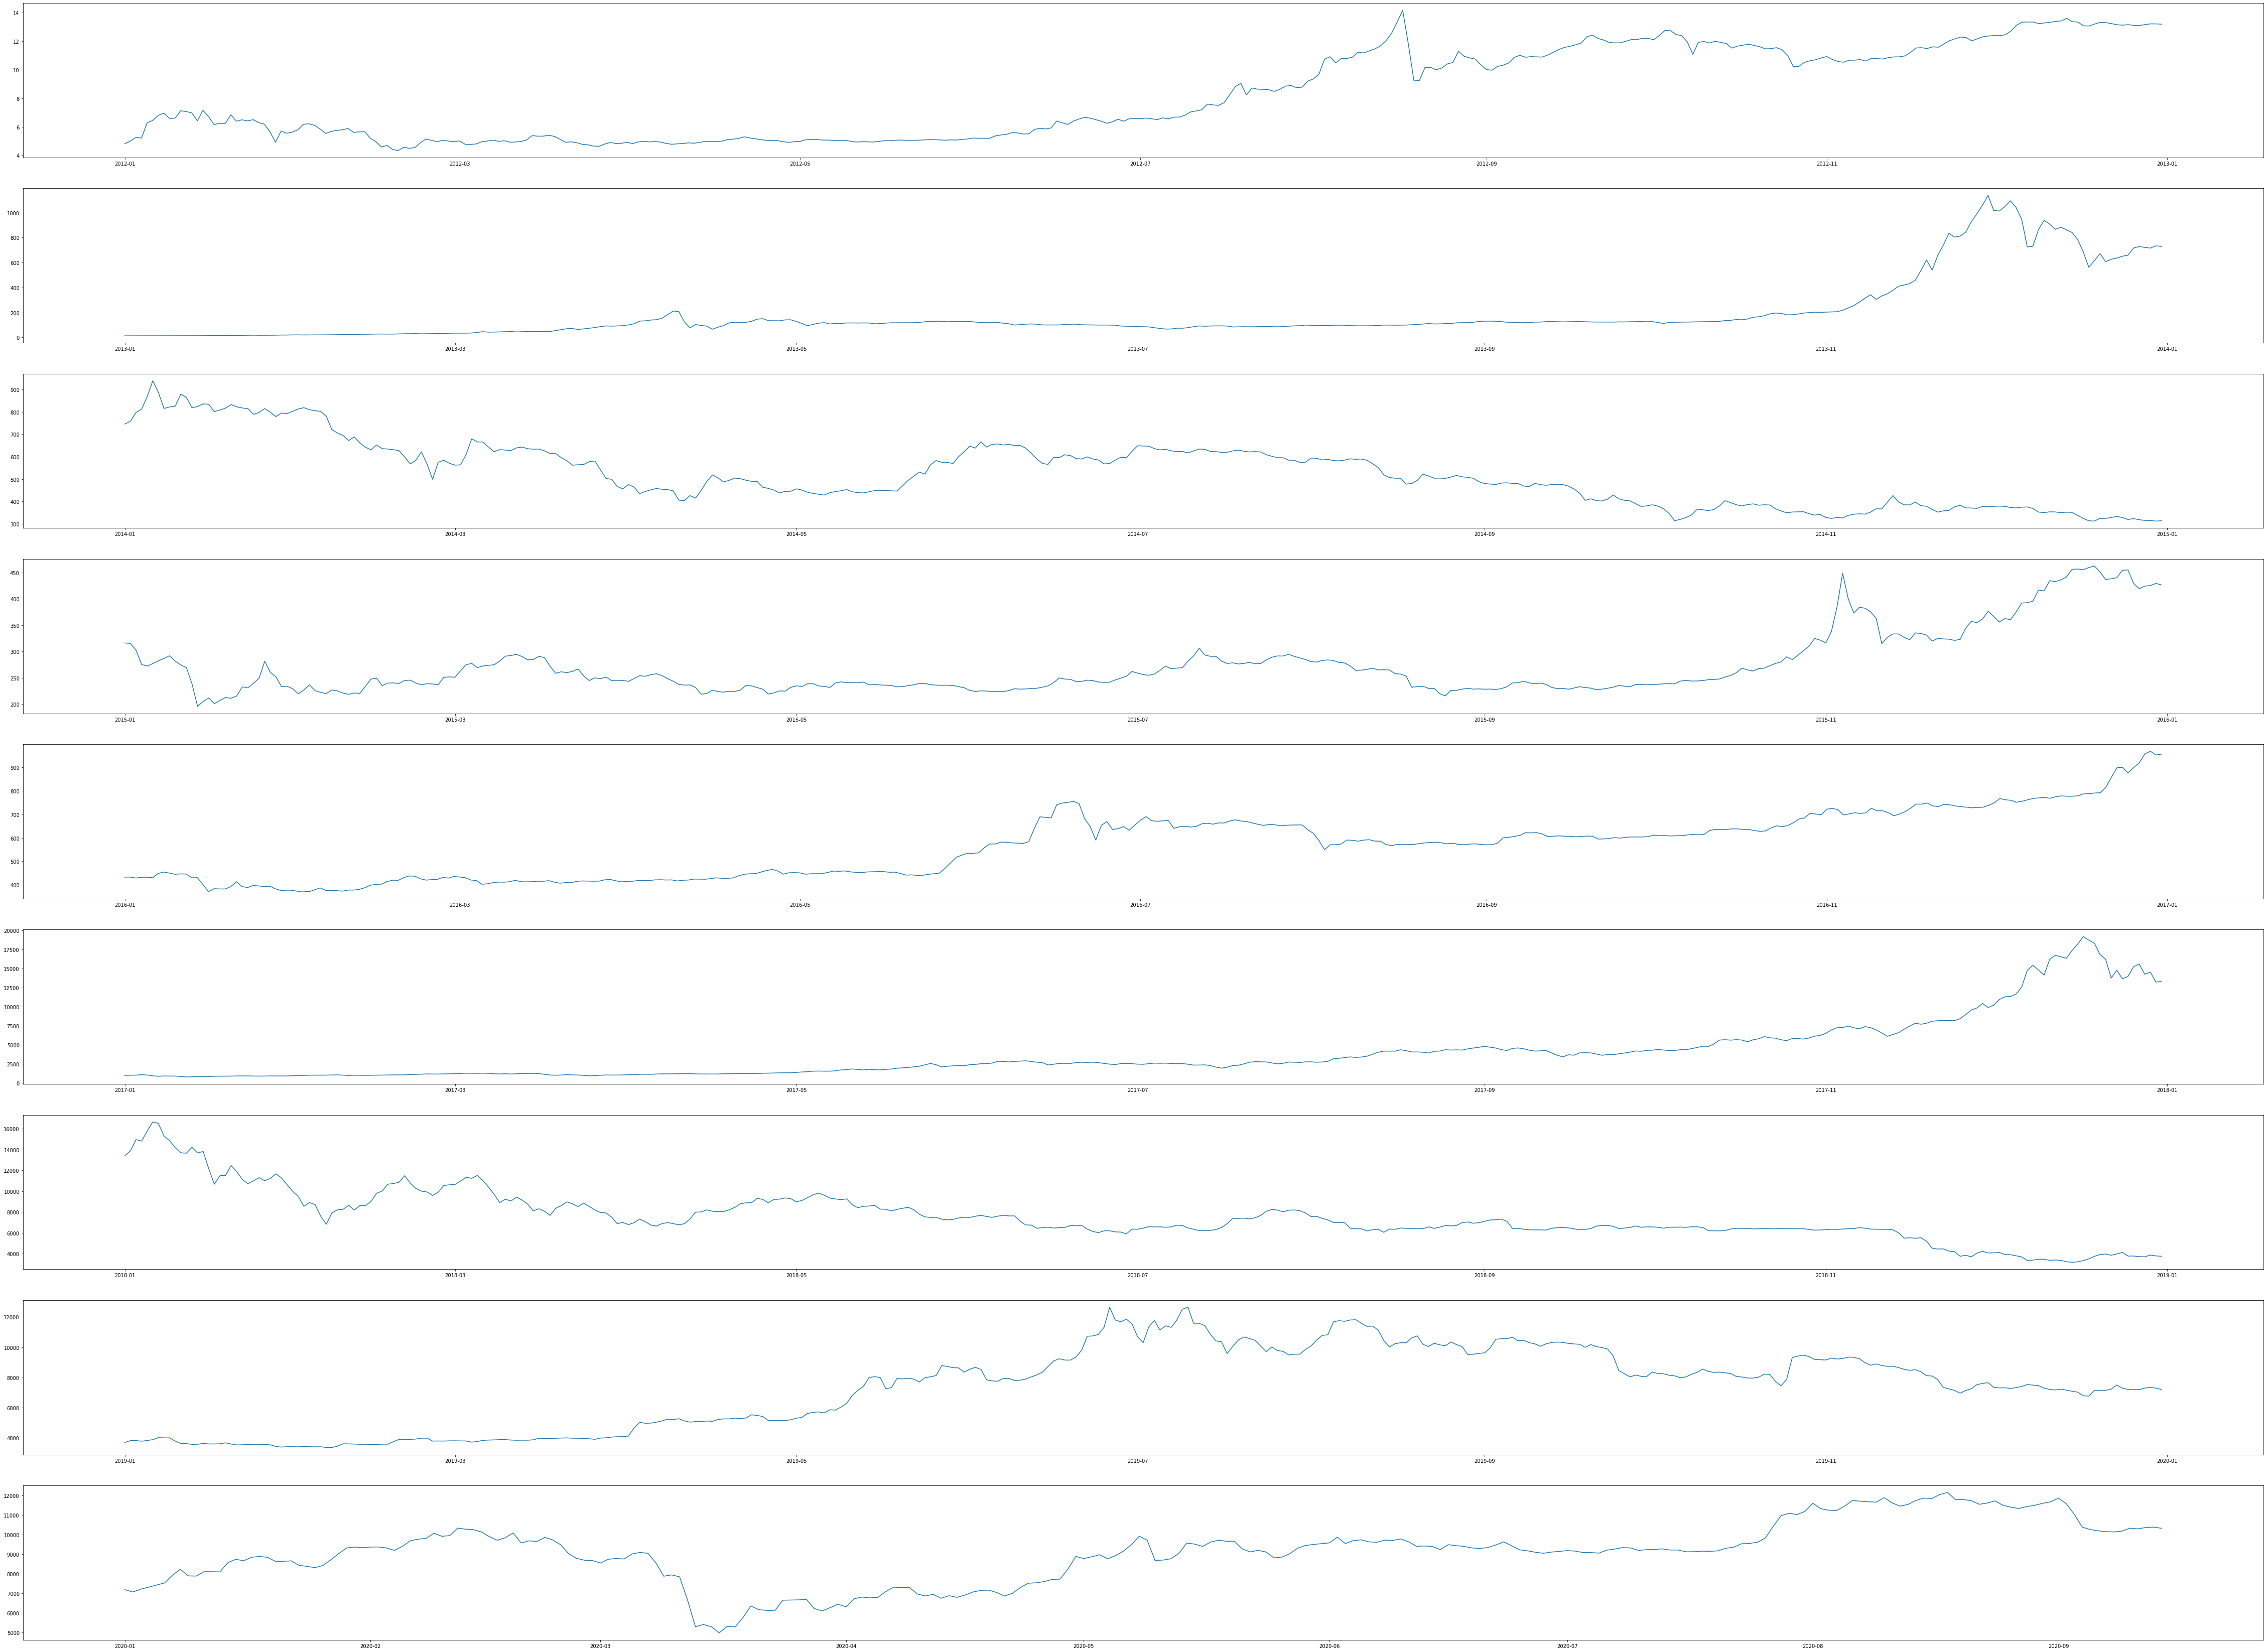

In [11]:
fig, (ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8, ax9) = plt.subplots(9, figsize=(80, 60))
#y_2012.plot(figsize=(19, 4))
ax1.plot(y_2012)
ax2.plot(y_2013)
ax3.plot(y_2014)
ax4.plot(y_2015)
ax5.plot(y_2016)
ax6.plot(y_2017)
ax7.plot(y_2018)
ax8.plot(y_2019)
ax9.plot(y_2020)

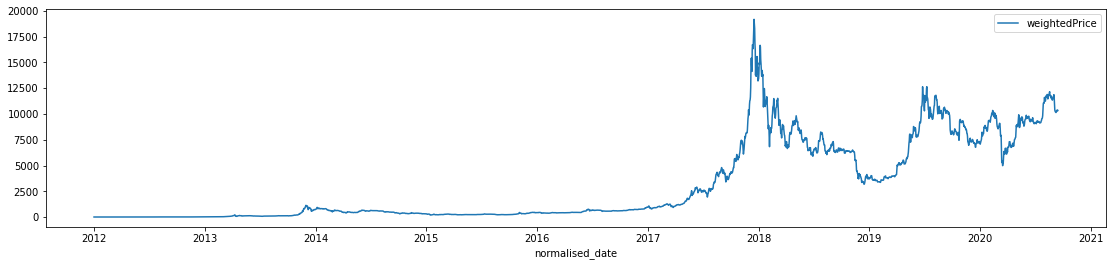

In [13]:
date_price_df.plot(figsize=(19, 4))
plt.show()


In [32]:
from statsmodels.tsa.stattools import adfuller

# time series testing requirements: since a time series is stationally, it implies the model lacks broad changes in mean/variance over time
print(f'Dickey–Fuller test: p={adfuller(y_2012.weightedPrice)[1]}')
plt.show()

# this p-value indicates that our series is not stationary with 99.88% confidence

Dickey–Fuller test: p=0.9059271297613438


In [14]:
print(len(date_price_df))

3177


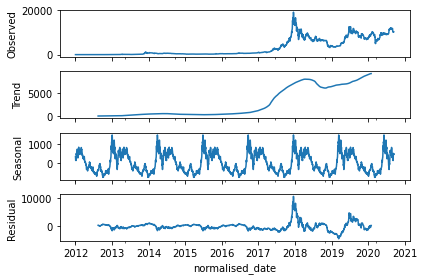

In [16]:
# using 1 week as freq
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(x=date_price_df['weightedPrice'], model='additive', freq=452)
fig = decomposition.plot()
plt.show()

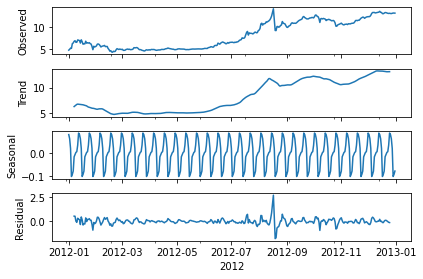

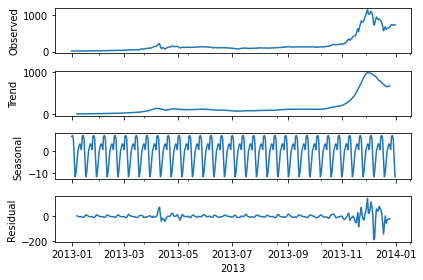

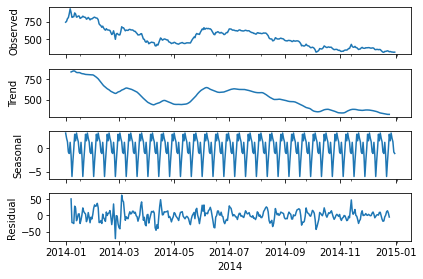

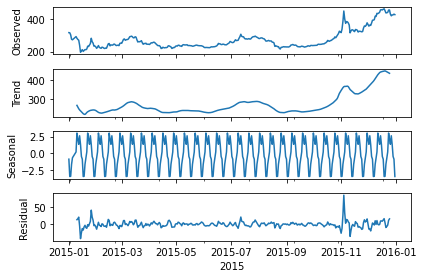

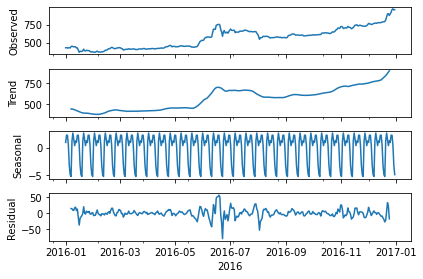

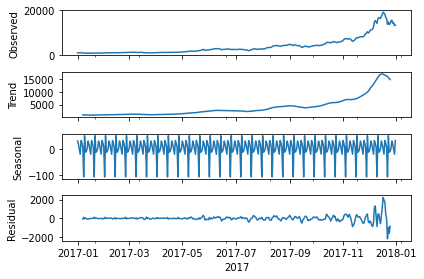

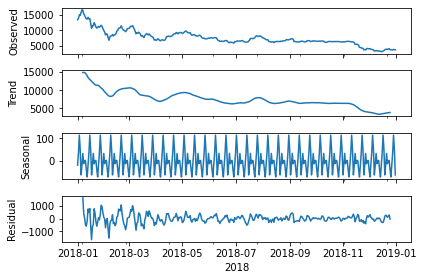

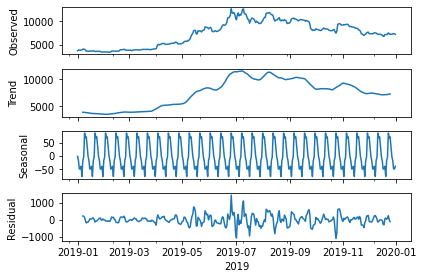

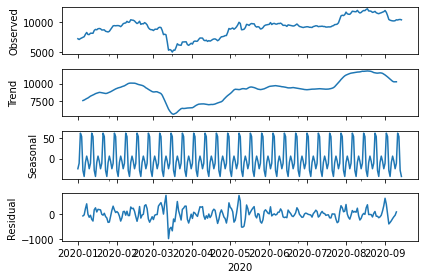

In [26]:
btc_dfs = [y_2012,y_2013,y_2014,y_2015,y_2016,y_2017,y_2018,y_2019,y_2020]

# performing seasonal decomposition with frequency as 12 per year (monthly)
start_date = 2012
for df in btc_dfs:
  frequency = 12
  if df is y_2020:
    frequency = 9
  decomposition = seasonal_decompose(x=df, model='additive', freq=frequency)
  fig = decomposition.plot()
  title = str(start_date)
  plt.xlabel(title)
  plt.show()
  start_date += 1

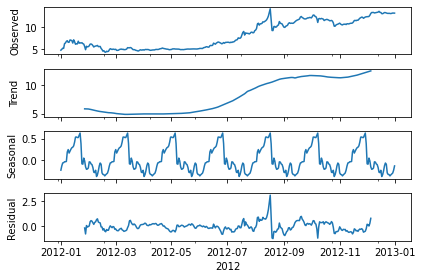

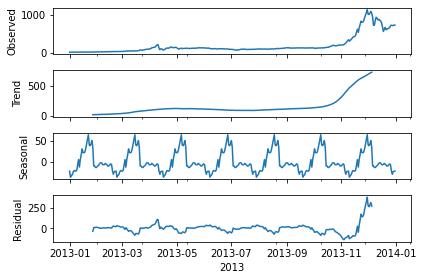

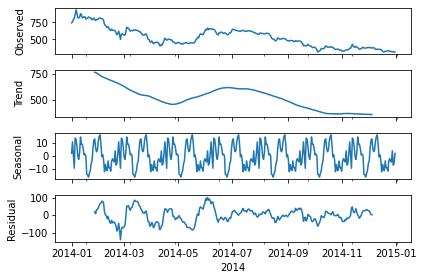

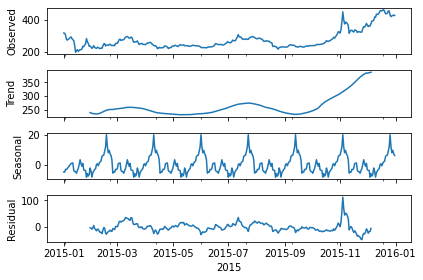

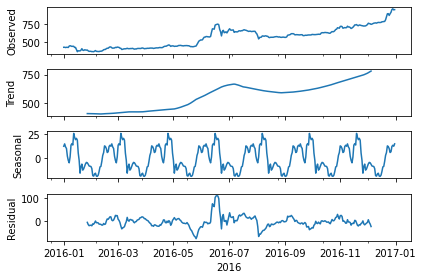

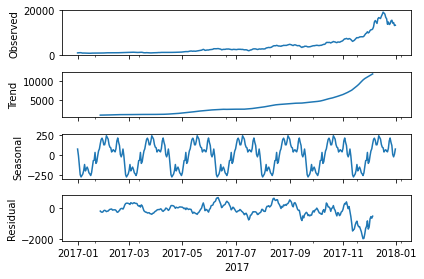

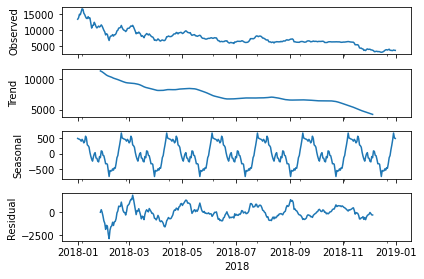

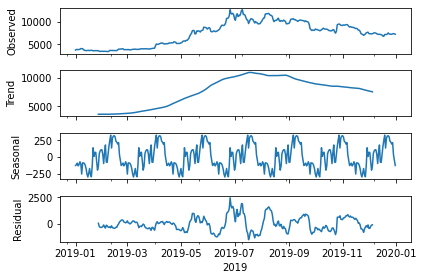

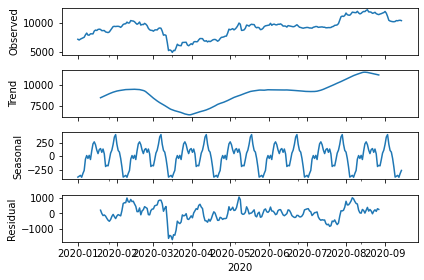

In [25]:
# performing seasonal decomposition with frequency as 52 per year (weekly)
start_date = 2012
for df in btc_dfs:
  frequency = 52
  if df is y_2020:
    frequency = 36
  decomposition = seasonal_decompose(x=df, model='additive', freq=frequency)
  fig = decomposition.plot()
  title = str(start_date)
  plt.xlabel(title)
  plt.show()
  start_date += 1